In [1]:
from skyfield.api import load
from skyfield.almanac import find_discrete, seasons
import datetime as dt

def get_season_dates(year):
    """Returns a dictionary with dates for equinoxes and solstices in the given year."""
    ts = load.timescale()
    eph = load('de421.bsp')  # Ephemeris data for precise astronomical calculations
    
    # Define time range for the year
    start = ts.utc(year, 1, 1)
    end = ts.utc(year, 12, 31)
    
    # Find dates for equinoxes and solstices
    time, events = find_discrete(start, end, seasons(eph))

    names = {
        0: 'Vernal equinox', 
        1: 'Summer solstice', 
        2: 'Autumnal equinox', 
        3: 'Winter solstice'
    }
    
    return {names[e]: t.utc_datetime() for t, e in zip(time, events)}

dates = get_season_dates(dt.datetime.now().year)
dates["Today"] = dt.datetime.now(dt.timezone.utc)
dates = {k:v for k, v in sorted(dates.items(), key=lambda x: x[1])}
dates

{'Today': datetime.datetime(2026, 2, 22, 19, 45, 20, 712825, tzinfo=datetime.timezone.utc),
 'Vernal equinox': datetime.datetime(2026, 3, 20, 14, 45, 57, 448680, tzinfo=datetime.timezone.utc),
 'Summer solstice': datetime.datetime(2026, 6, 21, 8, 24, 30, 347031, tzinfo=datetime.timezone.utc),
 'Autumnal equinox': datetime.datetime(2026, 9, 23, 0, 5, 13, 168825, tzinfo=datetime.timezone.utc),
 'Winter solstice': datetime.datetime(2026, 12, 21, 20, 50, 14, 175954, tzinfo=datetime.timezone.utc)}

In [2]:
from astral import Observer
from astral.sun import sun

latitude = 50.041187
longitude = 21.999121
observer = Observer(latitude=latitude, longitude=longitude)
for name, dt_utc in dates.items():
    date = dt_utc.date()
    s = sun(observer, date=date)
    sunrise_utc, sunset_utc = s["sunrise"], s["sunset"]
    dates[name] = (sunrise_utc, sunset_utc)

dates

{'Today': (datetime.datetime(2026, 2, 22, 5, 29, 56, 526881, tzinfo=datetime.timezone.utc),
  datetime.datetime(2026, 2, 22, 16, 1, 49, 77448, tzinfo=datetime.timezone.utc)),
 'Vernal equinox': (datetime.datetime(2026, 3, 20, 4, 35, 24, 103651, tzinfo=datetime.timezone.utc),
  datetime.datetime(2026, 3, 20, 16, 44, 27, 468699, tzinfo=datetime.timezone.utc)),
 'Summer solstice': (datetime.datetime(2026, 6, 21, 2, 22, 47, 585697, tzinfo=datetime.timezone.utc),
  datetime.datetime(2026, 6, 21, 18, 44, 50, 4960, tzinfo=datetime.timezone.utc)),
 'Autumnal equinox': (datetime.datetime(2026, 9, 23, 4, 19, 54, 633225, tzinfo=datetime.timezone.utc),
  datetime.datetime(2026, 9, 23, 16, 27, 58, 518415, tzinfo=datetime.timezone.utc)),
 'Winter solstice': (datetime.datetime(2026, 12, 21, 6, 28, 22, 914372, tzinfo=datetime.timezone.utc),
  datetime.datetime(2026, 12, 21, 14, 31, 42, 590027, tzinfo=datetime.timezone.utc))}

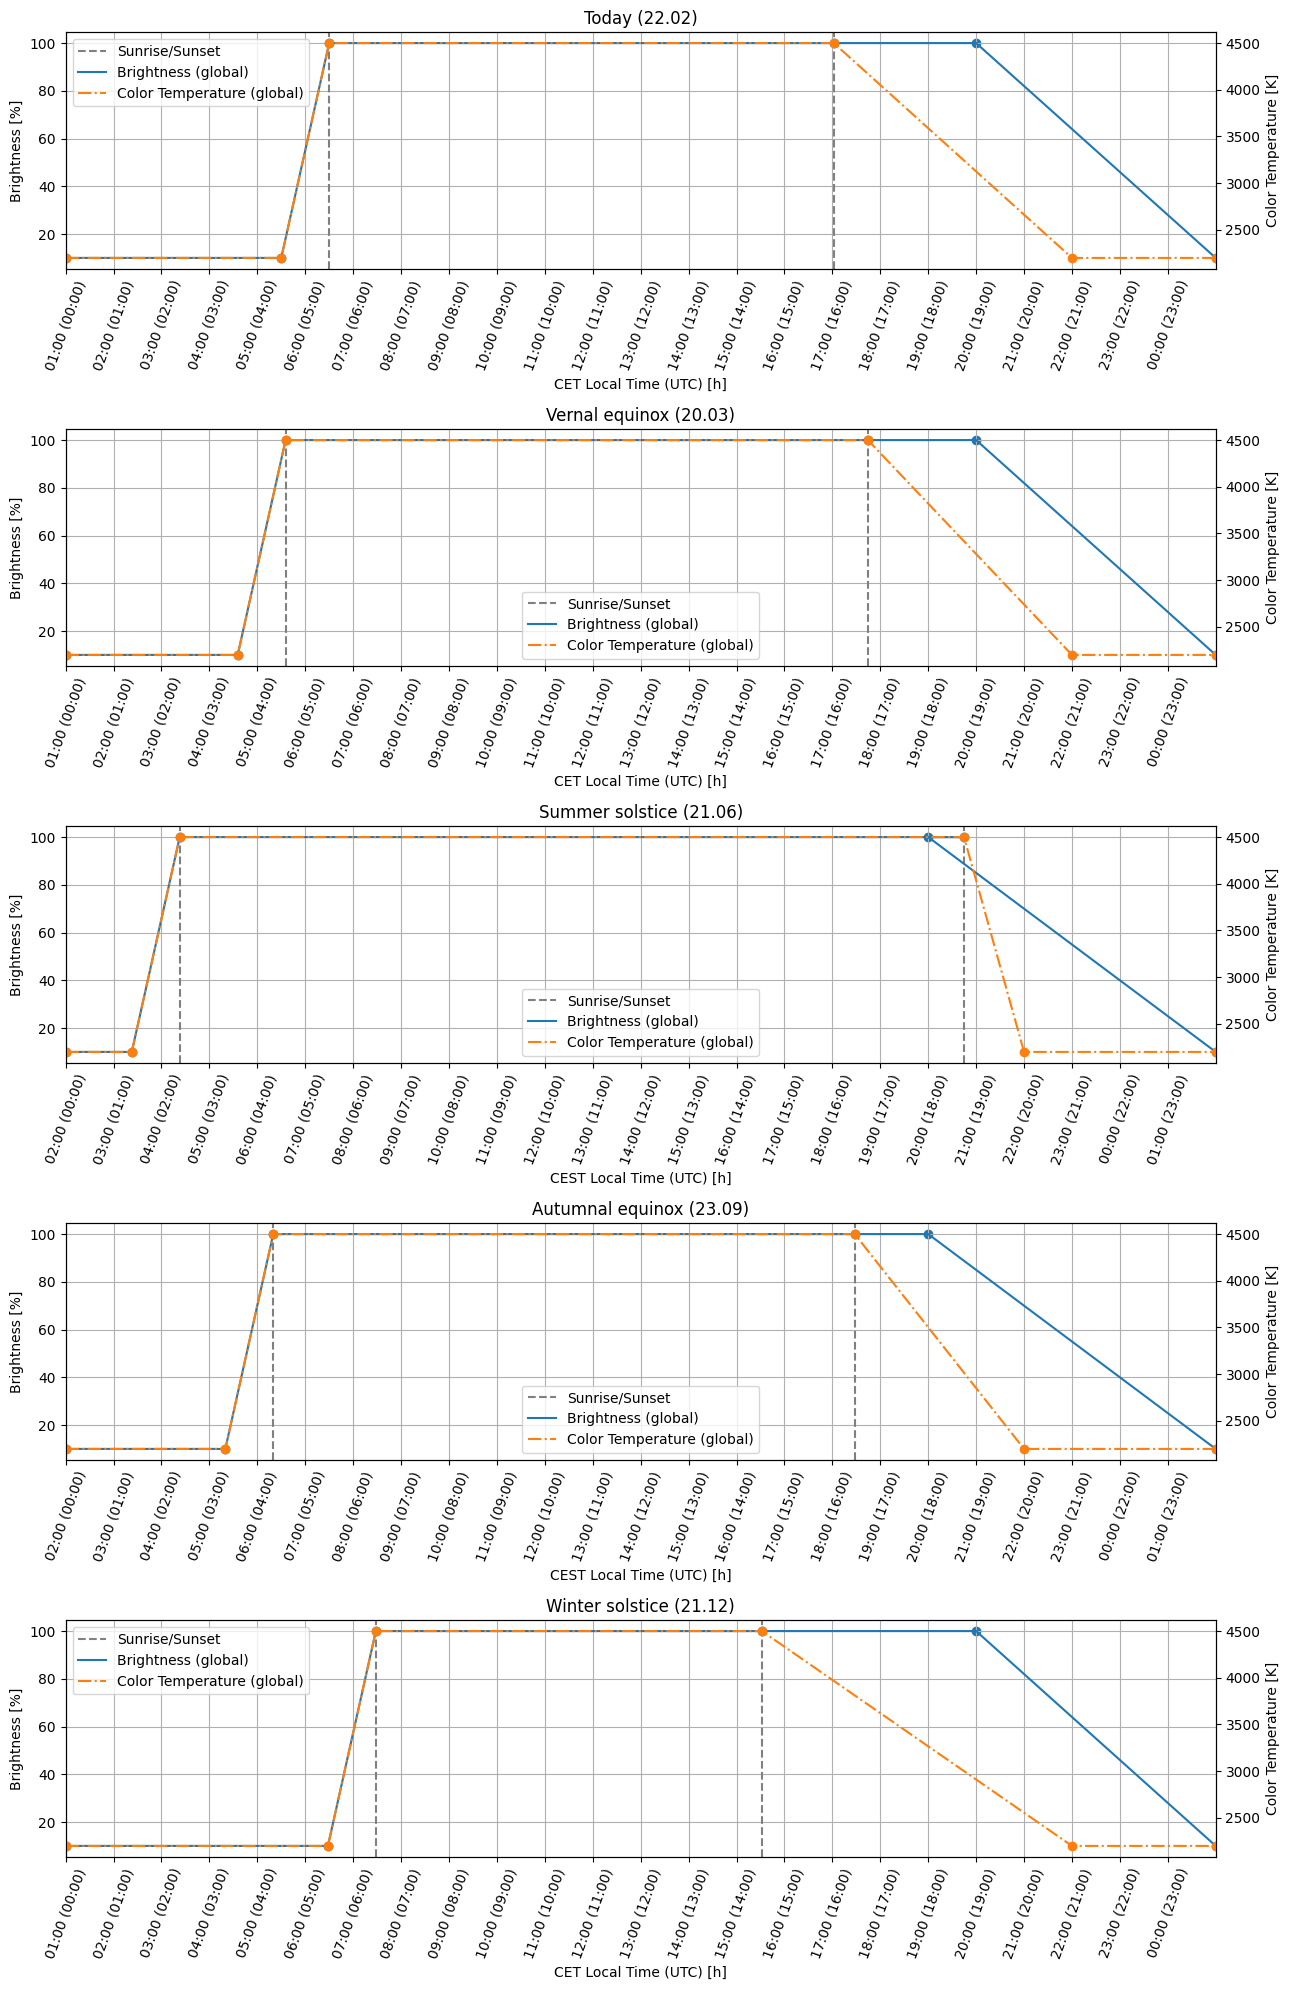

In [3]:
from zoneinfo import ZoneInfo
from matplotlib.axes import Axes
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker

fig, axs = plt.subplots(figsize=(13, 4 * len(dates)), nrows=len(dates), ncols=1)
axs: list[Axes]
warsaw_zi = ZoneInfo("Europe/Warsaw")
for i, (name, (sunrise_utc, sunset_utc)) in enumerate(dates.items()):
    sunrise_utc: dt.datetime
    sunset_utc: dt.datetime
    
    def get_utc_time(local_time: dt.time):
        return (dt.datetime.combine(sunrise_utc.date(), local_time, warsaw_zi)
                .astimezone(dt.timezone.utc)
                .time()) 

    b_utc_schedule = pd.DataFrame({
        "time": [
            dt.time.min, 
            (sunrise_utc - dt.timedelta(hours=1)).time(), 
            sunrise_utc.time(), 
            sunset_utc.time(), 
            get_utc_time(dt.time(hour=20)),
            dt.time.max],
        "global": [10, 10, 100, 100, 100, 10],
    })  # fmt: skip
    
    ct_utc_schedule = pd.DataFrame({
        "time": [
            dt.time.min, 
            (sunrise_utc - dt.timedelta(hours=1)).time(), 
            sunrise_utc.time(), 
            sunset_utc.time(), 
            get_utc_time(dt.time(hour=22)),
            dt.time.max],
        "global": [2200, 2200, 4500, 4500, 2200, 2200],
    })  # fmt: skip

    # Full datetime for matplotlib
    b_dtime = [(dt.datetime.combine(sunrise_utc.date(), t, dt.timezone.utc)) for t in b_utc_schedule["time"]]
    ct_dtime = [(dt.datetime.combine(sunrise_utc.date(), t, dt.timezone.utc)) for t in ct_utc_schedule["time"]]

    b_ax = axs[i]
    b_ax.set_ylabel('Brightness [%]')
    ct_ax = b_ax.twinx()
    ct_ax.set_ylabel('Color Temperature [K]')

    lines: list[Line2D] = []

    line_s = b_ax.axvline(sunrise_utc, color='gray', linestyle='--', linewidth=1.5, label='Sunrise/Sunset')
    b_ax.axvline(sunset_utc, color='gray', linestyle='--', linewidth=1.5, label='Sunrise/Sunset')
    lines += [line_s]

    # Common
    def dual_tz_fmt(x, pos=None):
        dt_utc = mdates.num2date(x, tz=dt.timezone.utc)
        dt_local = dt_utc.astimezone(warsaw_zi)
        return f"{dt_local.strftime('%H:%M')} ({dt_utc.strftime('%H:%M')})"

    b_ax.xaxis.set_major_formatter(mticker.FuncFormatter(dual_tz_fmt))
    b_ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    b_ax.grid(True)
    b_ax.set_xlabel(f'{sunrise_utc.astimezone(warsaw_zi).tzname()} Local Time (UTC) [h]')
    b_ax.set_xlim(b_dtime[0], b_dtime[-1])
    b_ax.tick_params("x", labelrotation=70)
    b_ax.set_title(f"{name} ({sunrise_utc.strftime("%d.%m")})")

    colors = iter(plt.cm.tab10.colors)
    for light_name in b_utc_schedule.columns[1:]:
        b_vals = b_utc_schedule[light_name]
        c = next(colors)
        line_b = b_ax.plot(b_dtime, b_vals, color=c, label=f'Brightness ({light_name})')
        lines += line_b
        b_ax.scatter(b_dtime, b_vals, color=c)

    for light_name in ct_utc_schedule.columns[1:]:
        color_temps = ct_utc_schedule[light_name]
        c = next(colors)
        line_ct = ct_ax.plot(ct_dtime, color_temps, color=c, linestyle="-.", label=f'Color Temperature ({light_name})')
        lines += line_ct
        ct_ax.scatter(ct_dtime, color_temps, color=c)

    labels = [l.get_label() for l in lines]
    b_ax.legend(lines, labels)

fig.tight_layout()